In [ ]:
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 30
batch_size = 128
learning_rate = 1e-3

In [ ]:
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, inp_dims=784, h_dims=400, z_dims=20):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(inp_dims, h_dims)
        self.linear2 = nn.Linear(h_dims, z_dims)
        self.linear3 = nn.Linear(h_dims, z_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        return self.linear2(x), self.linear3(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, inp_dims=784, h_dims=400, z_dims=2):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dims, h_dims)
        self.linear2 = nn.Linear(h_dims, inp_dims)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, inp_dims=784, h_dims=400, z_dims=2):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(inp_dims, h_dims, z_dims)
        self.decoder = Decoder(inp_dims, h_dims, z_dims)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decoder(z)
        return x_reconst, mu, log_var

In [ ]:
model = Autoencoder().to(device)
model

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=2, bias=True)
    (linear3): Linear(in_features=400, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=784, bias=True)
  )
)

torch.Size([60000, 28, 28])
torch.Size([60000])


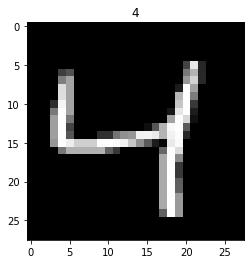

In [ ]:
# plot one example
print(dataset.data.size())     # (60000, 28, 28)
print(dataset.targets.size())   # (60000)
plt.imshow(dataset.data[2].numpy(), cmap='gray')
plt.title('%i' % dataset.targets[2])
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/30], Step [1/469], Reconst Loss: 140.9649, KL Div: 6.1511


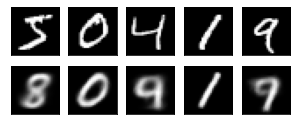

Epoch[6/30], Step [1/469], Reconst Loss: 143.8496, KL Div: 5.7779


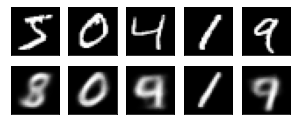

Epoch[30/30], Step [1/469], Reconst Loss: 142.0155, KL Div: 6.2387


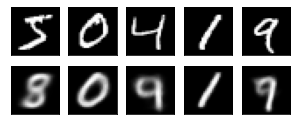

In [ ]:
# Start training

# original data (first row) for viewing
N_TEST_IMG = 5
view_data = torch.autograd.Variable(dataset.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.).cuda()

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if (i+1) % 10 == 0:
        #     print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
        #            .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item() / len(x), kl_div.item() / len(x)))
        if i % 200 == 0 and epoch % 2 == 0:
            # print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                    .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item() / len(x), kl_div.item() / len(x)))

            # plotting decoded image (second row)
            decoded_data, _, _ = model(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.cpu()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.cpu()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        x = x.to(device).view(-1, image_size)
        z, _ = autoencoder.encoder(x)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

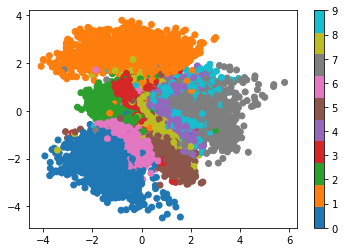

In [ ]:
plot_latent(model, data_loader)

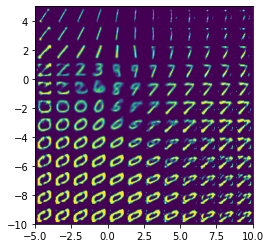

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    
plot_reconstructed(model)

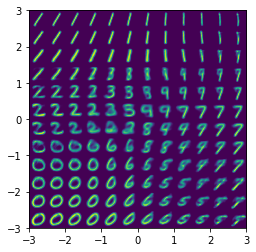

In [ ]:
plot_reconstructed(model, r0=(-3, 3), r1=(-3, 3))

In [ ]:
import os
from torchvision.utils import save_image

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
# with torch.no_grad():
#     # Save the sampled images
#     z = torch.randn(batch_size, z_dim).to(device)
#     out = model(z).view(-1, 1, 28, 28)
#     save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

#     # Save the reconstructed images
#     out, _, _ = model(x)
#     x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
#     save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))